Для визуализации изображений используйте функцию:

# Classification of Oxford Pets

|Студент| Плешков А.О. |
|:-----:|:-:|
|Группа|М8О-306Б-19|
|Вариант| 3 (нечётный) |
|Фреймворк| Tensorflow/Keras |

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Для начала загружаем датасет:

In [ ]:
import matplotlib.pyplot as plt

def display_images(l, titles = None, fontsize = 12):
    n = len(l)
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(l):
        ax[i].imshow(im.permute(1, 2, 0))
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i], fontsize = fontsize)
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.autonotebook import tqdm, trange
from torchvision.datasets import OxfordIIITPet
from torch.utils.data.dataset import random_split
from torchvision import datasets, models, transforms

Для начала приведем картинки к одному размеру:

In [ ]:
transform = transforms.Compose([transforms.Resize((200, 200)), transforms.ToTensor()])
dataset = OxfordIIITPet(root = "./", download = True, transform = transform)

In [ ]:
dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Делим dataset на training and validation части и помещаем в DataLoader:

In [ ]:
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size
print(test_size, train_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

736 2944


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': train_size, 'val': test_size}

In [ ]:
print(len(train_loader), len(val_loader))

46 12


In [ ]:
name_classes = dataset.classes

Запишем индексы кошек и собак для бинарной классификации:

In [ ]:
cats = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
dogs = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36]

In [ ]:
name_classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [ ]:
len(name_classes)

37

In [ ]:
inputs, classes = next(iter(train_loader))
inputs.shape

torch.Size([64, 3, 200, 200])

In [ ]:
display_images(inputs[:10])

Проверим соответствие картинки и лейбла в train_loader'е:

In [ ]:
plt.imshow(inputs[21].permute(1, 2, 0))
plt.show()
print(name_classes[classes[21]])

Pug


Проверим соответствие картинки и лейбла в val_loader'е:

In [ ]:
inputs, classes = next(iter(val_loader))
inputs.shape

torch.Size([64, 3, 200, 200])

In [ ]:
plt.imshow(inputs[20].permute(1, 2, 0))
plt.show()
print(name_classes[classes[20]])

Maine Coon


Переход на GPU:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Функция для обучения модели, возвращает лучшую модель в процессе тренировки, а также средний loss и accuracy на каждой эпохе:

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "val": []}
    acc_d = {'train': [], "val": []}
    t = trange(num_epochs, desc = "Epoch:")

    for epoch in t:
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in tqdm(dataloaders[phase], leave = False, desc = f"{phase} iter:"):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
              
                if phase == "train":
                    optimizer.zero_grad()

                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
            
            if phase == 'train':
                scheduler.step()
           
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            acc_d[phase].append(epoch_acc)
            
            t.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, losses, acc_d

Точность модели на датасете:

In [ ]:
def evaluate(model):
    model.eval()
    runninig_correct = 0
    for data in val_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        _, preds = torch.max(output, 1)
        runninig_correct += int(torch.sum(preds == labels))
    return runninig_correct / dataset_sizes['val']

Точность модели на бинарном датасете:

In [ ]:
def binary_evaluate(model):
    model.eval()
    runninig_correct = 0
    for data in val_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        _, preds = torch.max(output, 1)
        for idx, i in enumerate(labels):
            if i in cats:
                labels[idx] = 1
            else:
                labels[idx] = 0
        for idx, i in enumerate(preds):
            if i in cats:
                preds[idx] = 1
            else:
                preds[idx] = 0
        runninig_correct += int(torch.sum(preds == labels))
    return runninig_correct / dataset_sizes['val']

Строит Confusion Matrix:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def confusion_matrix_(model):
    model.eval()
    runninig_correct = 0
    y_pred = []
    y_true = []
    for data in val_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        _, preds = torch.max(output, 1)
        runninig_correct += int(torch.sum(preds == labels))
        y_pred += preds.tolist()
        y_true += labels.tolist()
    print("Accuracy model:", runninig_correct / dataset_sizes['val'])
    figure = plt.figure(figsize = (20, 5))
    matr2 = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize = (25, 20))
    ConfusionMatrixDisplay(matr2).plot(ax = ax)
    plt.show()

Вычисляем top-3 and top-5 accuracy:

In [ ]:
from sklearn.metrics import top_k_accuracy_score

def top_k_accuracy_score_(model):
    model.eval()
    runninig_correct = 0
    y_pred = []
    y_true = []
    for idx, data in enumerate(val_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        preds = torch.softmax(output, 1)
        preds = preds.cpu()
        labels = labels.cpu()
        if idx == 0:
            y_pred = np.array(preds.detach().numpy())
            y_true = np.array(labels.numpy())
        else:
            y_pred = np.concatenate((y_pred, preds.detach().numpy()))
            y_true = np.concatenate((y_true, labels.numpy()))
    print("Top-3 accuracy:", top_k_accuracy_score(y_true, y_pred, k = 3))
    print("Top-5 accuracy:", top_k_accuracy_score(y_true, y_pred, k = 5))

# VGG-16

In [ ]:
model_extractor = models.vgg16(pretrained = True)
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Замораживаем все слои и заменяем слои, относящиеся к классификации:

In [ ]:
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 25088
model_extractor.classifier = nn.Sequential(nn.Linear(in_features = num_features, out_features = 4096, bias = True), nn.ReLU(inplace = True),
                                           nn.Dropout(p = 0.5, inplace = False), nn.Linear(in_features = 4096, out_features = 37, bias = True))
model_extractor = model_extractor.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [ ]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_extractor, losses, acc_d = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=7)

Epoch::   0%|          | 0/7 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

Training complete in 4m 20s
Best val Acc: 0.750000


In [ ]:
torch.save(model_extractor.state_dict(), 'VGG-16.pth')

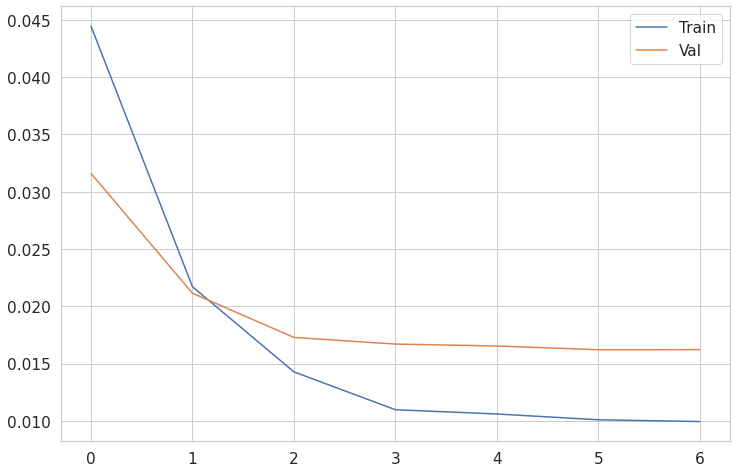

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.4)
plt.figure(figsize = (12, 8))
plt.plot(losses['train'], label = "Train")
plt.plot(losses['val'], label = "Val")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.4)
plt.figure(figsize = (12, 8))
plt.plot(acc_d['train'], label = "Train")
plt.plot(acc_d['val'], label = "Val")
plt.legend()
plt.show()

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.7500


In [ ]:
print("Cat/Dogs accuracy: {0:.4f}".format(binary_evaluate(model_extractor)))

Cat/Dogs accuracy: 0.9674


In [ ]:
confusion_matrix_(model_extractor)

Accuracy model: 0.75


<Figure size 1440x360 with 0 Axes>

In [ ]:
top_k_accuracy_score_(model_extractor)

Top-3 accuracy: 0.907608695652174
Top-5 accuracy: 0.9524456521739131


# VGG-19

In [ ]:
model_extractor = models.vgg19(pretrained = True)
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 25088
model_extractor.classifier[6] = nn.Linear(4096, 37)
model_extractor = model_extractor.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [ ]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model_extractor, losses, acc_d = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs = 5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

Training complete in 3m 12s
Best val Acc: 0.741848


In [ ]:
torch.save(model_extractor.state_dict(), 'VGG-19.pth')

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.2)
plt.figure(figsize = (15, 6))
plt.plot(losses['train'], label = "train")
plt.plot(losses['val'], label = "val")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.2)
plt.figure(figsize = (15, 6))
plt.plot(acc_d['train'], label = "train")
plt.plot(acc_d['val'], label = "val")
plt.legend()
plt.show()

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.7418


In [ ]:
print("Cat/Dogs accuracy: {0:.4f}".format(binary_evaluate(model_extractor)))

Cat/Dogs accuracy: 0.9701


Accuracy model: 0.7418478260869565


<Figure size 1440x360 with 0 Axes>

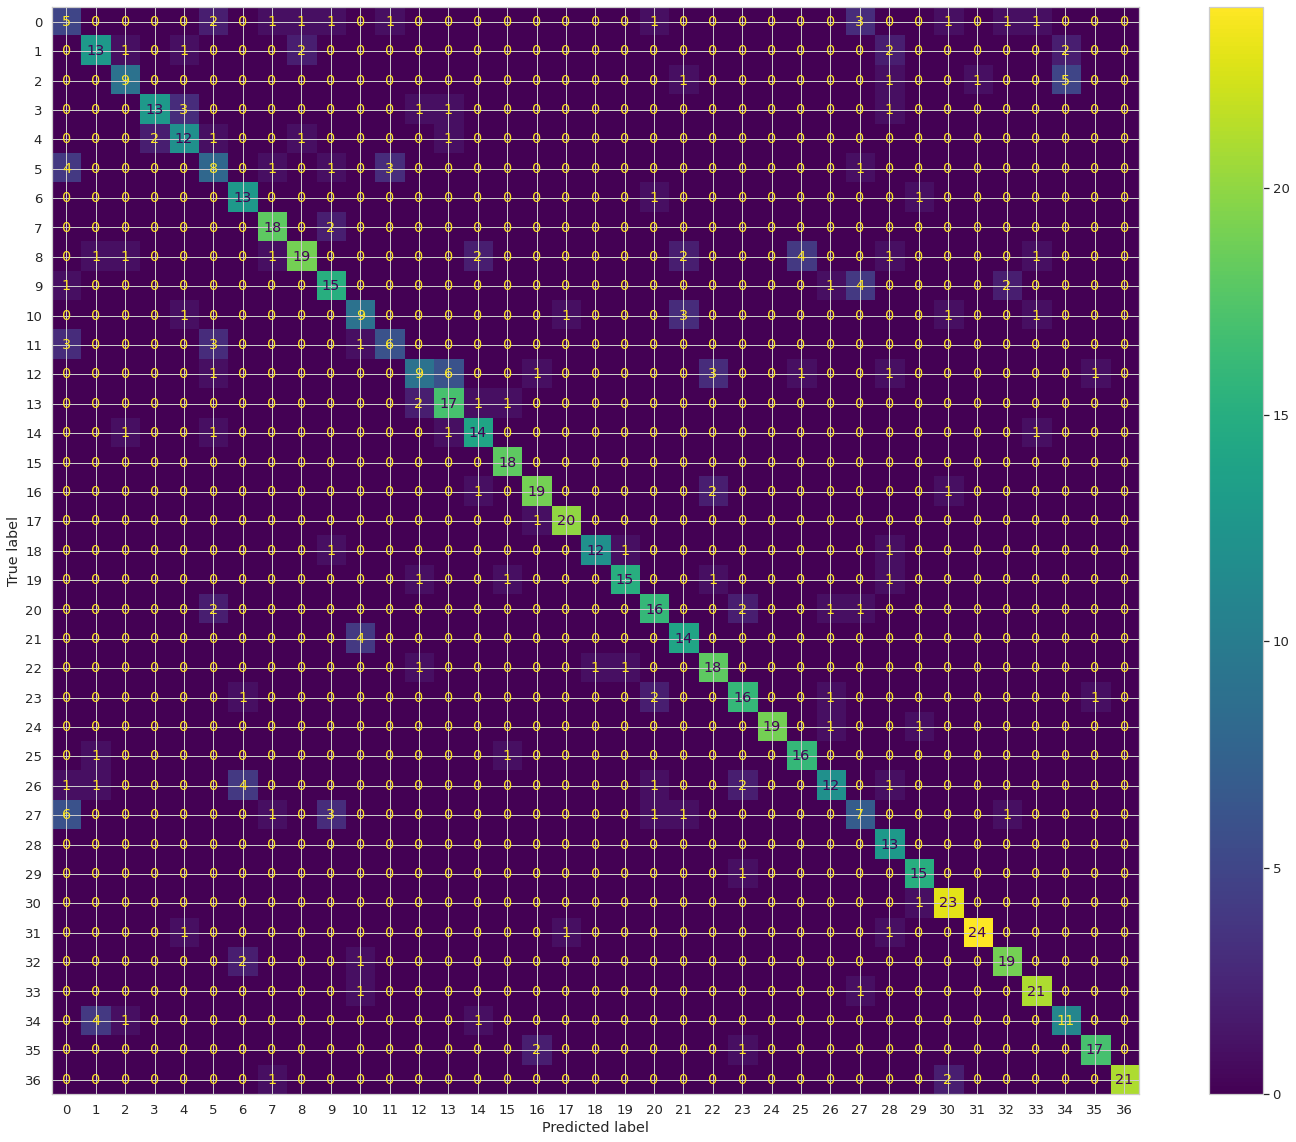

In [ ]:
confusion_matrix_(model_extractor)

In [ ]:
top_k_accuracy_score_(model_extractor)

Top-3 accuracy: 0.9198369565217391
Top-5 accuracy: 0.9633152173913043


# ResNet

In [ ]:
model_extractor = models.resnet18(pretrained = True)
model_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 512
model_extractor.fc = nn.Linear(in_features=num_features, out_features = 37, bias = True)
model_extractor = model_extractor.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_extractor.fc.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

In [ ]:
model_extractor, losses, acc_d = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs = 5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/46 [00:00<?, ?it/s]

val iter::   0%|          | 0/12 [00:00<?, ?it/s]

Training complete in 2m 6s
Best val Acc: 0.831522


In [ ]:
torch.save(model_extractor.state_dict(), 'resnet18.pth')

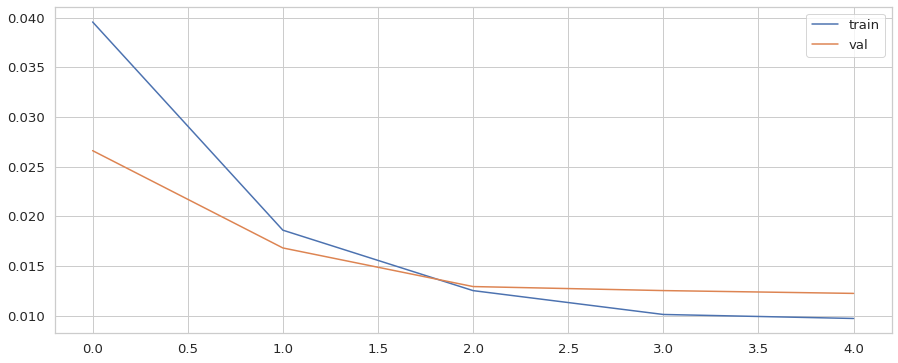

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.2)
plt.figure(figsize = (15, 6))
plt.plot(losses['train'], label = "train")
plt.plot(losses['val'], label = "val")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
sns.set(style = "whitegrid", font_scale = 1.2)
plt.figure(figsize = (15, 6))
plt.plot(acc_d['train'], label = "train")
plt.plot(acc_d['val'], label = "val")
plt.legend()
plt.show()

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.8315


In [ ]:
print("Cat/Dogs accuracy: {0:.4f}".format(binary_evaluate(model_extractor)))

Cat/Dogs accuracy: 0.9783


In [ ]:
confusion_matrix_(model_extractor)

Accuracy model: 0.8315217391304348


<Figure size 1440x360 with 0 Axes>

In [ ]:
top_k_accuracy_score_(model_extractor)

Top-3 accuracy: 0.9605978260869565
Top-5 accuracy: 0.9782608695652174


# Выводы

Таким образом, в ходе выполнения данной лабораторной работы были дообучены модели VGG-16/VGG-19 и ResNet на нашем датасете. В процессе дообучения заморозили все слои, кроме полносвязных, которые отвечают за классификацию, чтобы не испортить готовую молель. Для каждой модели вычислили средний loss и accuracy во время обучения и на валидации. Также были построены графики, посчитана точность бинарной классификации кошек против собак. Построили confution matrix и вычислили top-3 и top-5 accuracy.